# Master project XENON100 data analysis 
Data analysis with a Cesium source

In [1]:
# Boilerplate startup code
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from scipy.stats import norm


In [2]:
%matplotlib inline 
matplotlib.rc('font', size=16)                   # Use big fonts...
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # ... and big plots

In [3]:
# Import the XENON100 configuration from pax
from pax.configuration import load_configuration
pax_config = load_configuration('XENON100')

In [4]:
import hax
hax.init(main_data_paths=['/home/xenon100ws/cs'])

In [5]:
from pax import units

In [7]:
hax.ipython.code_hider()

In [6]:
from IPython.core.display import Image

In [7]:
# Usefull minitree :
class AreaPerChannel(hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['peaks.area_per_channel*', 'peaks.n_saturated_per_channel*']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        # Get the main interaction
        interaction = event.interactions[0]
        
        temp_dict = {}
        for channel, s2_area in enumerate(s2.area_per_channel):
            temp_dict['s2_area_channel_%d' % channel] = s2_area
        for channel, s1_area in enumerate(s1.area_per_channel):
            temp_dict['s1_area_channel_%d' % channel] = s1_area
            # get back: number of saturated samples per channel
        return temp_dict

In [8]:
class R2 (hax.minitrees.TreeMaker):
    # Activate the required branch while reading in the ROOT file
    # If you're too lazy to specify this, just put '*', but your TreeMaker will run slow!
    extra_branches = ['']
    __version__ = '0.0.1'
    
    def extract_data(self, event):
        # If there are no interactions at all, we can't extract anything...
        if not len(event.interactions):
            return dict()
            
        # Get the main interaction
        interaction = event.interactions[0]
        
        # Get the main S1 and main S2
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        
        return dict(r2= interaction.x**2+interaction.y**2)

# Cesium data :

In [9]:
dataset=['cs_data']
dataset2=['bg_data']

In [10]:
# use hax on our data
data = hax.minitrees.load(dataset, treemakers=[R2, 'Basics'], force_reload=True)
data_bg=hax.minitrees.load(dataset2)

Found minitree at ./cs_data_R2.root
Don't know a dataset named cs_data, trying to find it anyway...


100%|██████████| 73000/73000 [00:09<00:00, 7832.52it/s] 


Created minitree R2 for dataset cs_data
Found minitree at ./cs_data_Basics.root
Don't know a dataset named cs_data, trying to find it anyway...


100%|██████████| 73000/73000 [00:27<00:00, 2697.44it/s]


Created minitree Basics for dataset cs_data
Found minitree at ./bg_data_Basics.root


In [11]:
data.head(3)

,index,r2,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,largest_coincidence,...,largest_other_s2,largest_unknown,largest_veto,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z
0,0,161.729210,0,961.797417,346486.489376,1.506141e+09,57271.648438,0,1434281213038128128,0.0,...,87.425171,5.813081,3.354424,739.834900,0.239834,224951.84375,0.385503,12.646893,1.336158,-9.907995
1,1,NaN,1,NaN,NaN,1.506141e+09,NaN,1,1434281213056877056,0.0,...,28.465683,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,145.137039,2,2204.481122,603613.357377,1.506141e+09,26413.947266,2,1434281213082299904,0.0,...,198081.515625,0.000000,5.200140,1538.614014,0.225008,421063.87500,0.286033,-3.884181,11.403955,-4.569613


# First Analysis 

In [12]:
# Require a proper S1 >0
data = data[data['s1'] > 0]
# Require a proper S2 >0
data = data[data['s2'] > 0]
data = data[(data['cs1'] > 0) & (data['cs2'] > 0)]

print("Selected %d events" % len(data))

print ("with S1 and S2 >0")


Selected 34206 events
with S1 and S2 >0


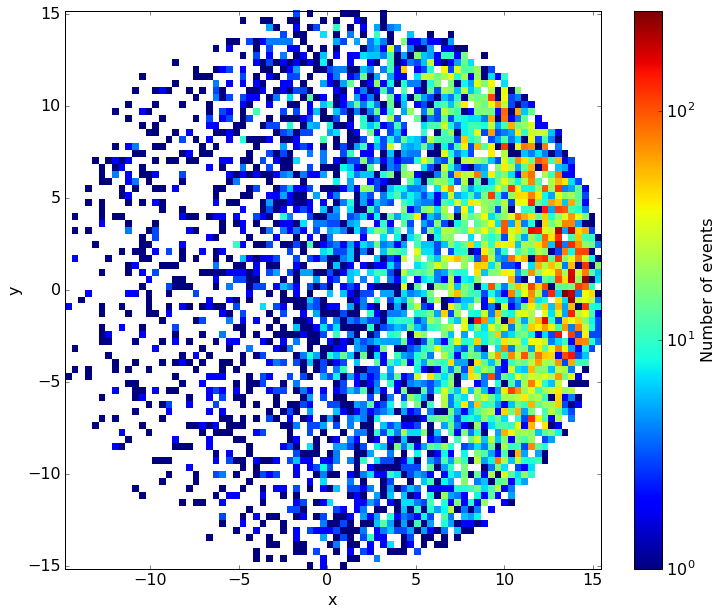

In [14]:
# plot x against y with the number of events in colorbar

plt.hist2d(data['x'], data['y'],
           bins=80,
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('plot1' + '.png', format='png', dpi=300)
plt.show()

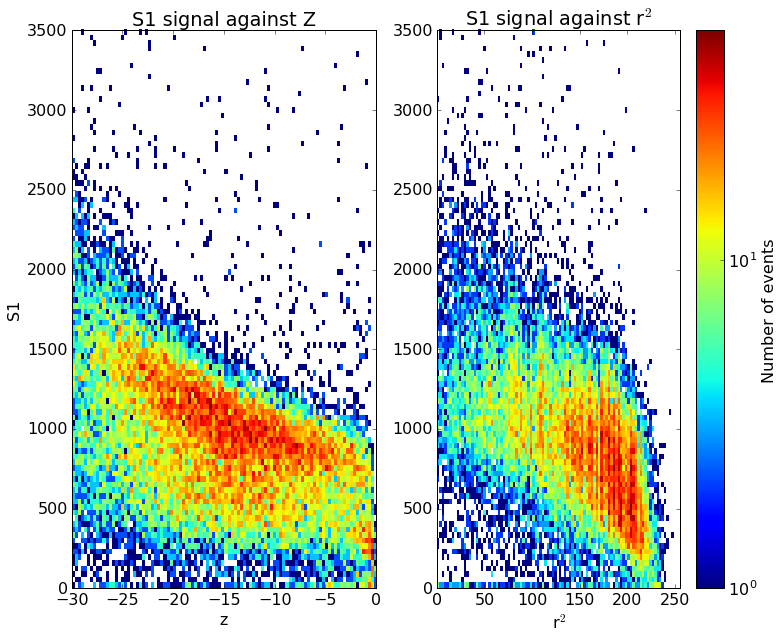

In [15]:
# plot S1 and cS1 in function of the position of the interaction with the number of events in colorbar

plt.subplot(121)
plt.hist2d(data['z'], data['s1'],range = [[-30,0],[0,3500]],
           bins=100,
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)

plt.xlabel('z')
plt.ylabel('S1')
plt.title('S1 signal against Z')

plt.subplot(122)
plt.hist2d(data['r2'], data['s1'],range = [[0,16**2],[0,3500]],
           bins=100,
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('r$^2$')

plt.title('S1 signal against r$^2$')

plt.savefig('plot2' + '.png', format='png', dpi=300)
plt.show()

The light collection efficiency of S1 and cS1 depends on the position of the interaction in the TPC

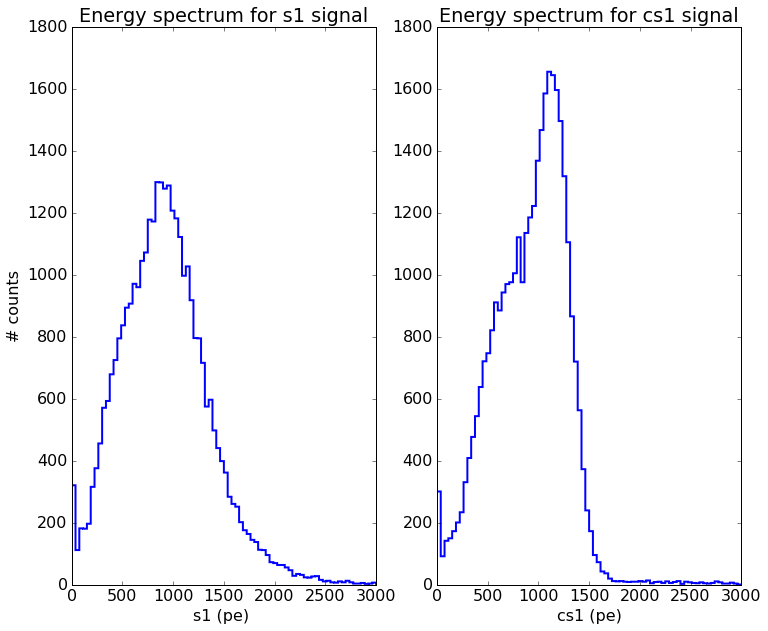

In [15]:
# Energy spectrum for S1 and cS1

plt.subplot(121)
plt.hist(data['s1'], bins = 80, range = (0,3000),histtype='step',lw=2)
plt.ylabel('# counts')
plt.xlabel('s1 (pe) ')
plt.ylim(0,1800)
plt.title('Energy spectrum for s1 signal')

plt.subplot(122)
plt.hist(data['cs1'], bins = 80, range = (0,3000),histtype='step',lw=2)

plt.xlabel('cs1 (pe)')
plt.title('Energy spectrum for cs1 signal')

plt.savefig('plot3' + '.png', format='png', dpi=300)

plt.show()


Better energy resolution for cS1

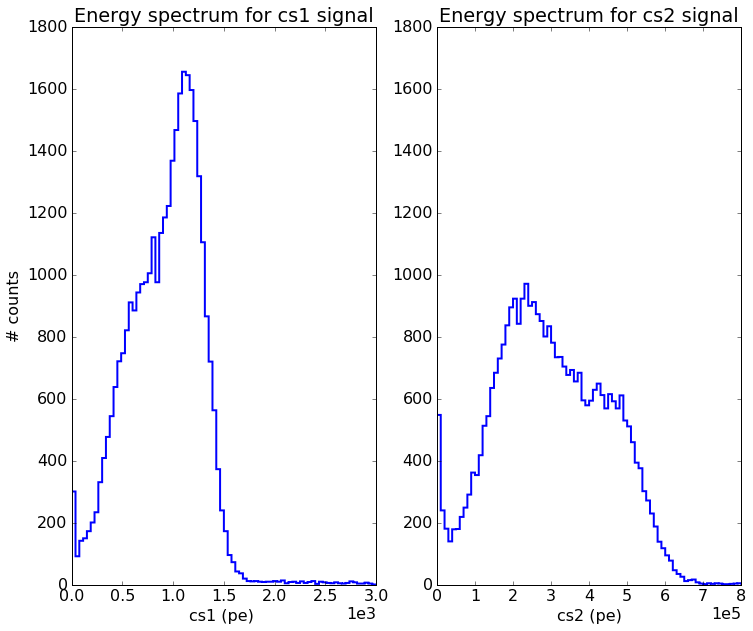

In [17]:
plt.subplot(121)
plt.hist(data['cs1'], bins = 80, range = (0,3000),histtype='step',lw=2)
plt.ylabel('# counts')
plt.xlabel('cs1 (pe) ')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.title('Energy spectrum for cs1 signal')

plt.subplot(122)
plt.hist(data['cs2'], bins = 80, range = (0,8e5),histtype='step',lw=2)

plt.xlabel('cs2 (pe)')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylim(0,1800)
plt.title('Energy spectrum for cs2 signal')
plt.savefig('plot4' + '.png', format='png', dpi=300)

plt.show()


# Selection of the photopeak 


In [18]:
data = hax.minitrees.load(dataset)
# Require a proper S1
data = data[data['s1'] > 0]
# Require a proper S2
data = data[data['s2'] > 0]
data = data[(data['cs1'] > 0) & (data['cs2'] > 0)]

print("Selected %d events" % len(data))

print ("with S1 and S2 >0")

Found minitree at ./cs_data_Basics.root
Selected 34206 events
with S1 and S2 >0


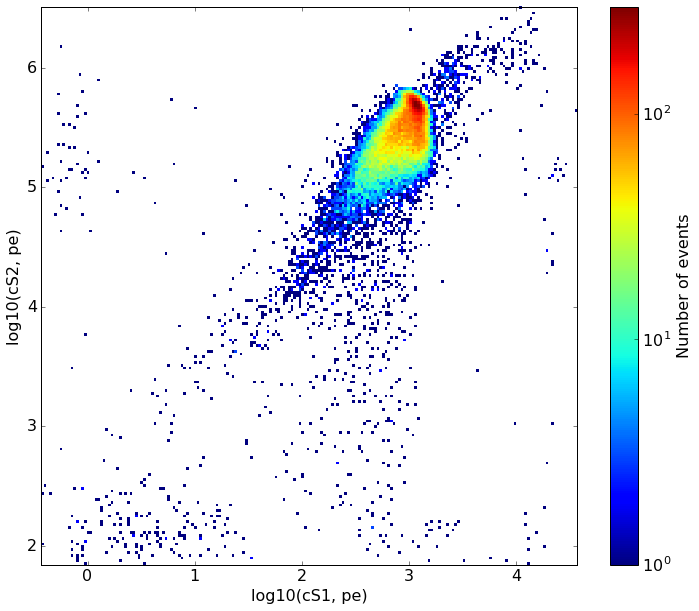

In [19]:
# Make an cS1 vs cS2 histogram

plt.hist2d(np.log10(data['cs1']),np.log10(data['cs2']), 
           bins=200, 
           norm=matplotlib.colors.LogNorm()   # Logarithmic color scale
)
plt.colorbar(label='Number of events')
plt.xlabel('log10(cS1, pe)')
plt.ylabel('log10(cS2, pe)')
plt.axhline(13.1,color='red')
plt.axvline(7.05,color='red')
plt.savefig('Copy3_Plot1' + '.png', format='png', dpi=300)
plt.show()

Using cS2_tot_bottom 

In [16]:
data = hax.minitrees.load(dataset)

s2_tot_bottom = []    
for i in range(0,len(data['cs2'])):
    s2_tot_bottom.append((1 - data['s2_area_fraction_top'][i])*data['cs2'][i])
    
print(len(s2_tot_bottom))


Found minitree at ./cs_data_Basics.root
73000


34206


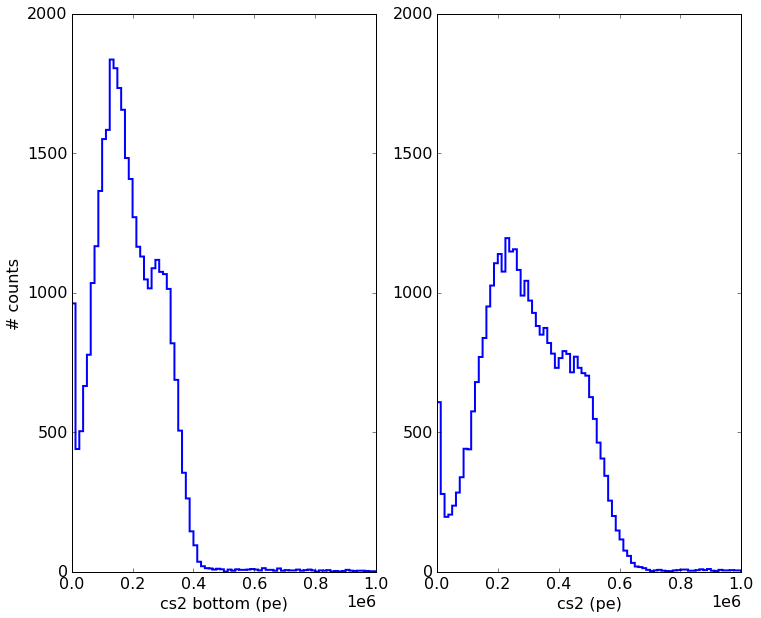

In [18]:
new_s2_tot_bottom = [] #Create an array 
for i in range(0,len(s2_tot_bottom)):
    if (data['cs1'][i] > 0 ) & (data['cs2'][i] > 0) & (s2_tot_bottom[i]>1):
        new_s2_tot_bottom.append(s2_tot_bottom[i])
print(len(new_s2_tot_bottom))  


plt.subplot(121)
plt.hist(new_s2_tot_bottom, bins = 80 , range=[0,1e6],histtype='step',lw=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('# counts')
plt.xlabel('cs2 bottom (pe)')


plt.subplot(122)
plt.hist(data['cs2'], bins = 80 , range=[0,1e6],histtype='step',lw=2)


plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.ylim(0,2000) 

plt.xlabel('cs2 (pe)')



plt.savefig('Copy3_Plot2' + '.png', format='png', dpi=300)
plt.show()

Better energy resolution for cS2_tot_bottom 

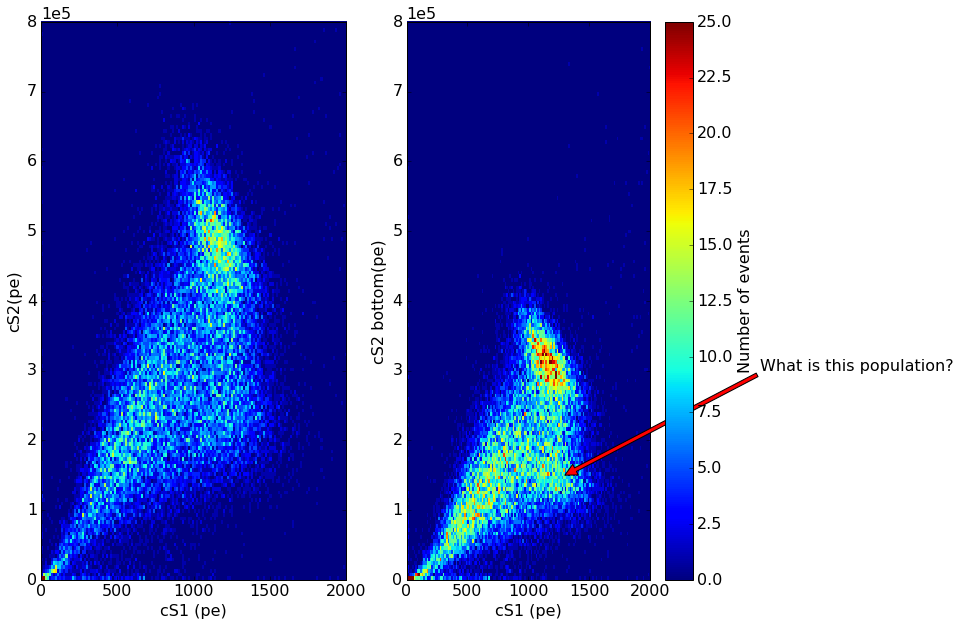

In [22]:
#Make an cS1 vs cS2_tot_bottom histogram
data = data[(data['cs1'] > 0) & (data['cs2'] > 0)]
plt.subplot(121)
plt.hist2d(data['cs1'],data['cs2'], bins=150, range =([0,2000],[0,8e5]), vmin =0, vmax =25)
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2(pe)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.subplot(122)
plt.hist2d(data['cs1'],np.array(new_s2_tot_bottom),bins=150, range =([0,2000],[0,8e5]), vmin =0, vmax =25)
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 bottom(pe)')

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.colorbar(label='Number of events')
plt.annotate('What is this population?', xy=(1300, 1.5e5) , xytext=(2900, 3e5),arrowprops=dict(facecolor='red', shrink=1))
plt.savefig('Copy3_Plot3' + '.png', format='png', dpi=300)

plt.show()

Found minitree at ./cs_data_Basics.root


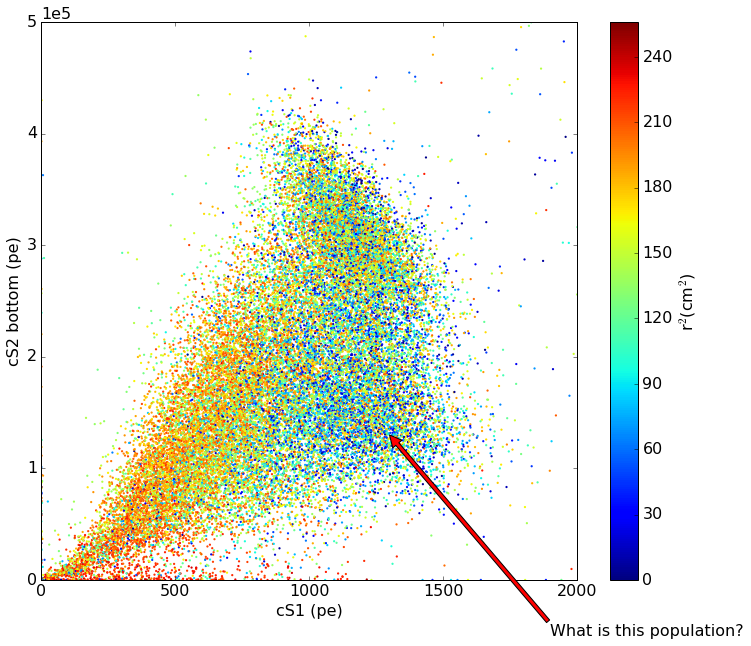

In [59]:
# Localisation of the unknown population in the TPC 
data = hax.minitrees.load(dataset)
data=data[data['cs1']>0]

plt.scatter(data['cs1'],new_s2_tot_bottom, c = data['x']**2+data['y']**2, vmin =0, vmax =16**2, marker = '.', 
            edgecolor = 'none', s=20)

plt.xlim(0,2000)
plt.ylim(0,500000)


plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 bottom (pe)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.annotate('What is this population?', xy=(1300, 1.3e5) , xytext=(1900, -0.5e5),arrowprops=dict(facecolor='red', shrink=1))
plt.colorbar(label='r$^2$(cm$^2$)')


plt.savefig('Copy3_Plot4' + '.png', format='png', dpi=300)



plt.show()

The unknown population is on the middle of the TPC, due to background ?

In [19]:
data_bg=hax.minitrees.load(dataset2)
s2_tot_bottom_bg = []    
for i in range(0,len(data_bg['cs2'])):
    s2_tot_bottom_bg.append((1 - data_bg['s2_area_fraction_top'][i])*data_bg['cs2'][i])
    

Found minitree at ./bg_data_Basics.root


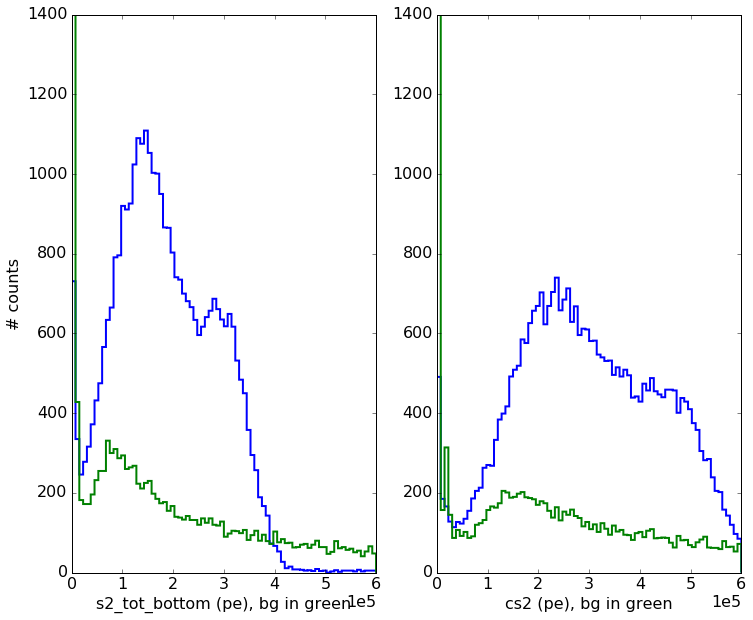

In [22]:
new_s2_tot_bottom_bg = []
for i in range(0,len(s2_tot_bottom_bg)):
    if (data_bg['cs1'][i] > 0 ) & (data_bg['cs2'][i] > 0):
        new_s2_tot_bottom_bg.append(s2_tot_bottom_bg[i])


plt.subplot(121)

plt.hist(new_s2_tot_bottom, bins = 80 , range=[0,0.6e6],histtype='step',lw=2)
plt.hist(new_s2_tot_bottom_bg, bins = 80 , range=[0,0.6e6],histtype='step',lw=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('# counts')
plt.xlabel('s2_tot_bottom (pe), bg in green')
plt.ylim(0,1400)

plt.subplot(122)
plt.hist(data['cs2'], bins = 80 , range=[0,0.6e6],histtype='step',lw=2)
plt.hist(data_bg['cs2'], bins = 80 , range=[0,0.6e6],histtype='step',lw=2)
plt.ylim(0,1400)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('cs2 (pe), bg in green')
plt.savefig('Copy3_Plot5' + '.png', format='png', dpi=300)
plt.show()


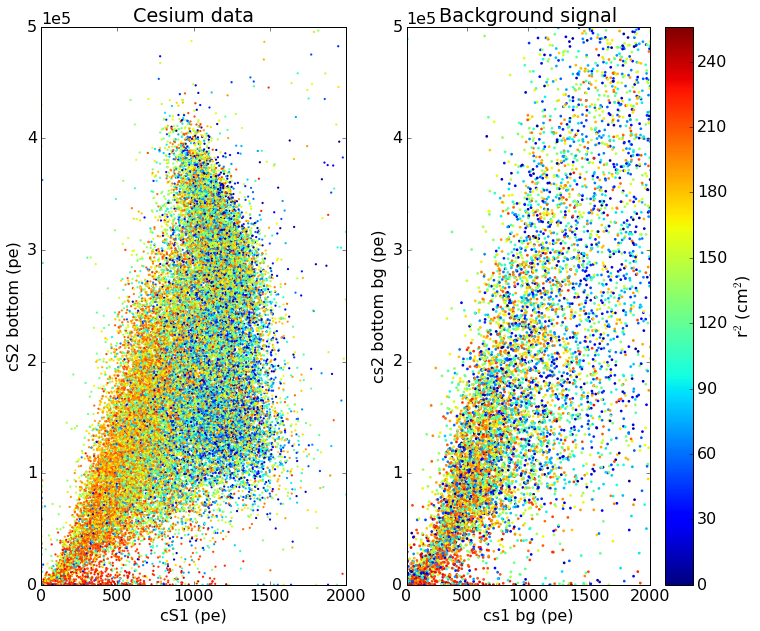

In [26]:
data_bg=data_bg[(data_bg['drift_time']>0) & (data_bg['cs1']>0)]
# print(len(data_bg))
# print(len(np.array(new_s2_tot_bottom_bg)))

plt.subplot(121)
plt.scatter(data['cs1'],new_s2_tot_bottom, c = data['x']**2+data['y']**2, vmin =0, vmax =16**2, marker = '.', 
            edgecolor = 'none', s=20)
plt.xlim(0,2000)
plt.ylim(0,500000)
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 bottom (pe)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Cesium data')
plt.subplot(122)
plt.scatter(data_bg['cs1'],np.array(new_s2_tot_bottom_bg), c = data_bg['x']**2+data_bg['y']**2, 
            vmin =0, vmax =16**2, marker = '.', edgecolor = 'none', s=30)
plt.xlim(0,2000)
plt.ylim(0,500000)
plt.xlabel('cs1 bg (pe)')
plt.ylabel('cs2 bottom bg (pe)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.title('Background signal')
plt.colorbar(label ='r$^2$ (cm$^2$)')
plt.savefig('Copy3_Plot6' + '.png', format='png', dpi=300)
plt.show()

Apparently, the unknown population is not a background one. 
What is it ?



# Double Scatter Events 

In [23]:
data=hax.minitrees.load(dataset)

def do_cut(cut, name=''):
    """Does a cut (specified as boolean array or Series) on df, modifying it in place.
    Additionally, prints out passthrough info
    """
    
    global data    # This lets us modify df, which lives outside the function
    n_before = len(data)
    data = data[cut]
    print("%s cut: %d events removed (%0.2f%% passthrough)" % (
            name, n_before - len(data), len(data)/n_before * 100))


Found minitree at ./cs_data_Basics.root


In [24]:
do_cut(data['cs1'] > 0, 'At least an interaction')
do_cut(data['largest_other_s2'] < 2000, 'Double scatter (absolute)')
do_cut(data['largest_other_s2'] < 0.5 * data['cs2'], 'Double scatter (relative)')
print('lenght data=',len(data))


At least an interaction cut: 38794 events removed (46.86% passthrough)
Double scatter (absolute) cut: 11079 events removed (67.61% passthrough)
Double scatter (relative) cut: 36 events removed (99.84% passthrough)
lenght data= 23091


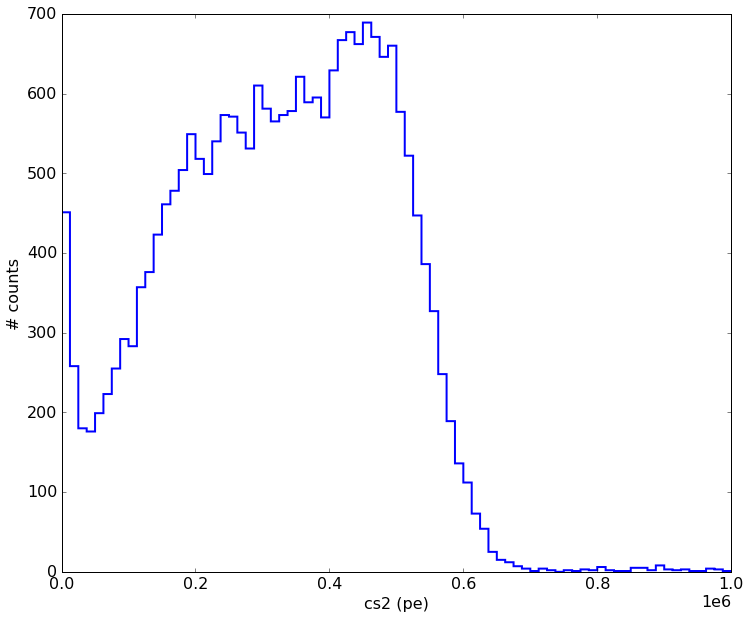

In [25]:
plt.hist(data['cs2'], bins = 80 , range=[0,1e6],histtype='step',lw=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('# counts')
plt.xlabel('cs2 (pe)')
plt.savefig('Copy3_Plot8' + '.png', format='png', dpi=300)
plt.show()

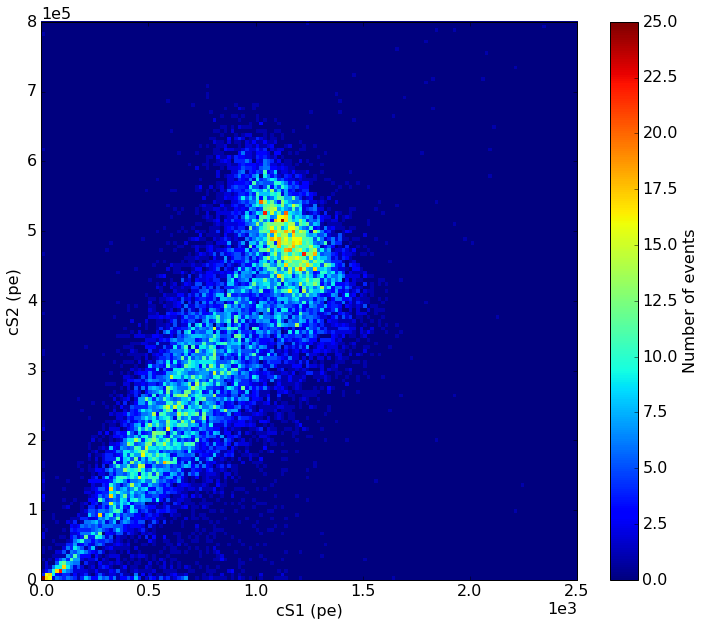

In [17]:
plt.hist2d(data['cs1'],data['cs2'], bins=150, range =([0,2500],[0,8e5]), vmin =0, vmax =25)
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 (pe)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.savefig('Copy3_Plot9' + '.png', format='png', dpi=300)
plt.colorbar(label='Number of events')
plt.show()

Here we already see that our unknowm population is gone !

In [26]:
data2 = hax.minitrees.load(dataset)
cs2_tot_bottom = []    
for i in range(0,len(data2['cs2'])):
    cs2_tot_bottom.append((1 - data2['s2_area_fraction_top'][i])*data2['cs2'][i])
    
print(len(cs2_tot_bottom))

Found minitree at ./cs_data_Basics.root
73000


23091


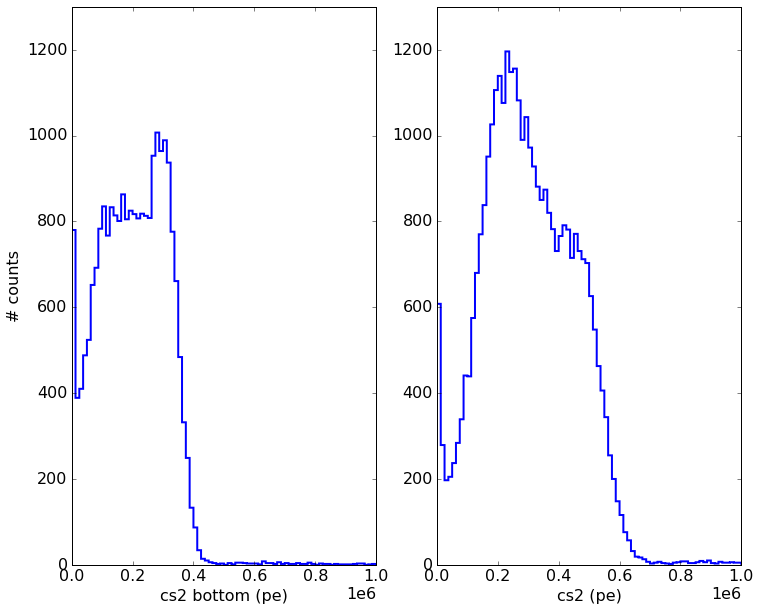

In [32]:

new_cs2_tot_bottom = []
for i in range(0,len(cs2_tot_bottom)):
    if (data2['cs1'][i] > 0 ) & (data2['largest_other_s2'][i] < 2000) & (data2['largest_other_s2'][i] < 0.5 * data2['cs2'][i]): # cut double scatter events
        new_cs2_tot_bottom.append(cs2_tot_bottom[i])
print(len(new_cs2_tot_bottom))  
plt.title('double scatter event cut')

plt.subplot(121)
plt.hist(new_cs2_tot_bottom, bins = 80 , range=[0,1e6],histtype='step',lw=2)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('# counts')
plt.xlabel('cs2 bottom (pe)')
plt.ylim(0,1300)


plt.subplot(122)
plt.hist(data2['cs2'], bins = 80 , range=[0,1e6],histtype='step',lw=2)
plt.ylim(0,1300)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('cs2 (pe)')
plt.savefig('Copy3_Plot10' + '.png', format='png', dpi=300)
plt.show()

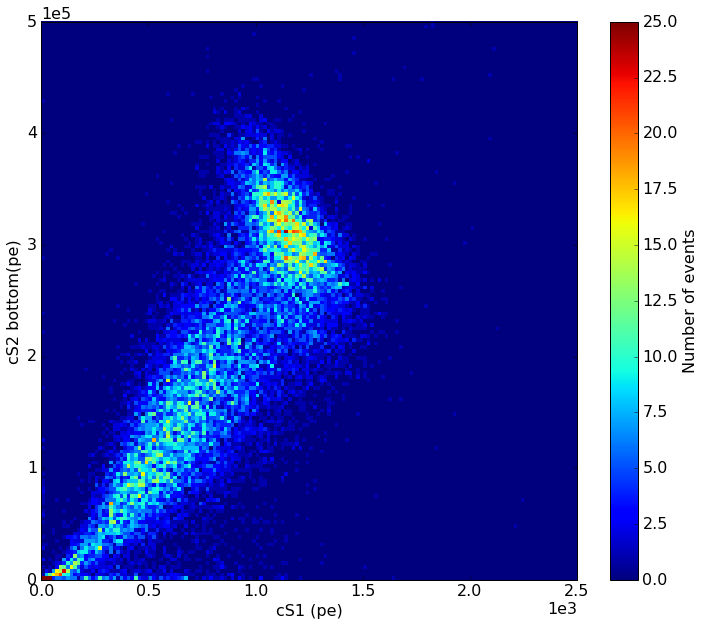

In [20]:
plt.hist2d(data['cs1'],np.array(new_cs2_tot_bottom), bins=150, range =([0,2500],[0,5e5]), vmin =0, vmax =25)
plt.xlabel('cS1 (pe)')
plt.ylabel('cS2 bottom(pe)')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.colorbar(label='Number of events')
plt.savefig('Copy3_Plot11' + '.png', format='png', dpi=300)
plt.show()

Now, we have to find the anti-correlation angle between cS1 and cS2_tot_bottom

Found minitree at ./cs_data_Basics.root
23091
23091


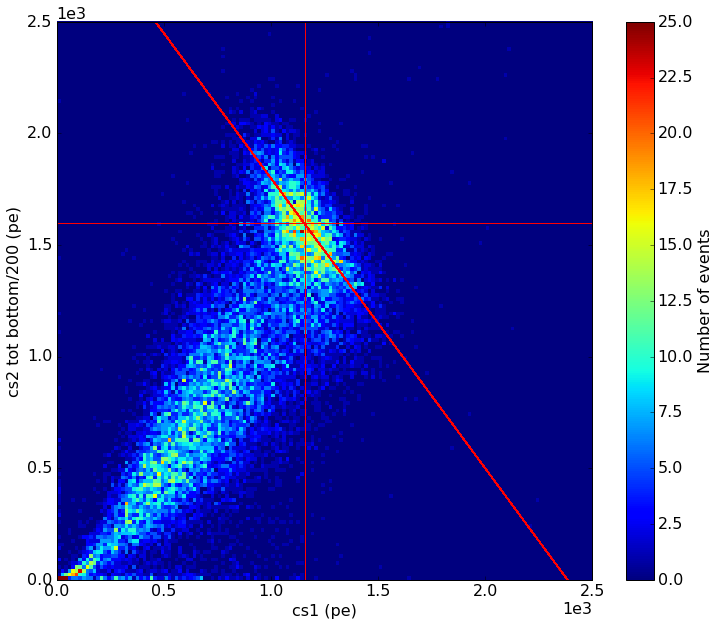

In [38]:
data=hax.minitrees.load(dataset)
new_cs1= []
for i in range(0,len(data['cs1'])):
    if (data['cs1'][i] > 0 ) & (data['largest_other_s2'][i] < 2000) & (data['largest_other_s2'][i] < 0.5 * data['cs2'][i]):
        new_cs1.append(data['cs1'][i])

print (len(new_cs1))
print (len(new_cs2_tot_bottom))
x=np.array(new_cs1)
y=-1.3*x+3100
plt.plot(x,y, color='red')

        
plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200, bins=150, range =([0,2500],[0,2500]), vmin =0, vmax =25)

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.colorbar(label='Number of events')
plt.axvline(1160,color='red')
plt.axhline(1600,color='red')

plt.ylabel('cs2 tot bottom/200 (pe)')
plt.xlabel('cs1 (pe)')
plt.savefig('Copy3_Plot12' + '.png', format='png', dpi=300)
plt.show()


# Combined Energy Scale (CES)
Erik's code

In [39]:

from recarray_tools import filter_on_fields, group_by, append_fields
from tqdm import tqdm
from scipy.optimize import curve_fit
from pax.formats import flat_data_formats
file_format = 'hdf5'
ioformat = flat_data_formats[file_format]()

In [40]:
# Some functions that'll be used
def func_poly_2(x,a,b,c):
    return a + b*x + c*x**2
def func_exp(x,a,tau):
    return a*np.exp(-x/tau)
def func_gauss(x,A,mu,sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

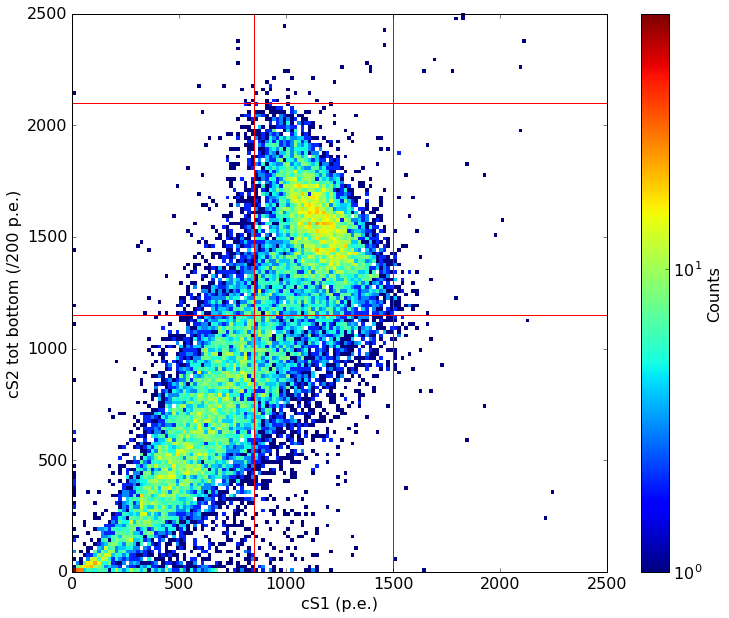

In [41]:
# We have to fit a Gaussian fonction to the ellipse in the red lines
from matplotlib.colors import LogNorm


plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200, bins=(150,150), range =([0,2500],[0,2500]),cmin=1,norm=LogNorm())
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.axvline(850,color='red')
plt.axvline(1500,color='red')
plt.axhline(1150,color='red')
plt.axhline(2100,color='red')
plt.savefig('Copy3_Plot13' + '.png', format='png', dpi=300)


plt.show()

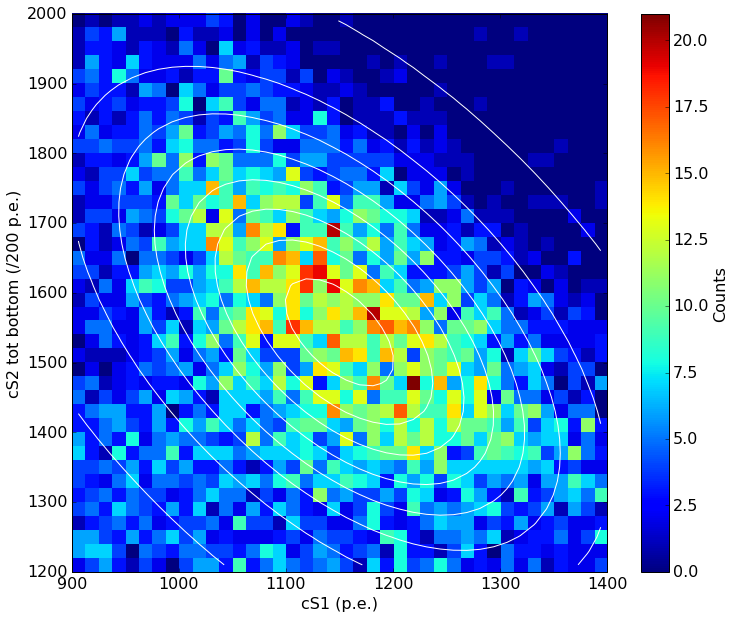

[  1.16561269e+01   1.14993654e+03   1.54358315e+03   2.13538897e+02
  -9.91481625e+01   1.11473674e+00   1.21504997e+00]


In [42]:
# Settings!
binsize = 40
range_s1 = (900,1400)
range_s2 = (1200,2000)

# This is the function to fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

s1s2hist = plt.hist2d(np.array(new_cs1),(np.array(new_cs2_tot_bottom)/200),
         bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.

for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):

initial_guess = (20,1140,1550,100,500,0.78,0)

popt, pcov = curve_fit(twoD_Gaussian, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([twoD_Gaussian((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')
plt.savefig('Copy3_Plot14' + '.png', format='png', dpi=300)

plt.show()

print(popt)

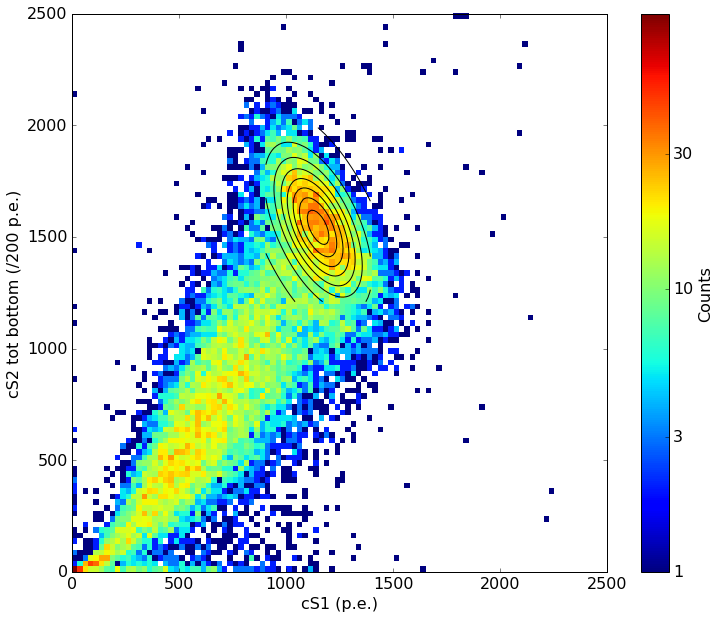

In [43]:

plt.hist2d(np.array(new_cs1),np.array(new_cs2_tot_bottom)/200,
           bins=(100,100),range=((0,2500),(0,2500)),cmin=1,norm=LogNorm())
cbar = plt.colorbar(label = 'Counts',ticks=[1,3,10,30,100])
cbar.set_ticklabels([1,3,10,30,100])
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 tot bottom (/200 p.e.)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')

plt.savefig('Copy3_Plot15' + '.png', format='png', dpi=300)


plt.show()

In [44]:
# We are moving to energy space!
energy_cs1= np.array(new_cs1)/popt[1]*662
energy_cs2=(np.array(new_cs2_tot_bottom)/200)/popt[2]*662
print(energy_cs1)
print(energy_cs2)

[ 553.69132975  666.81102791  320.66175811 ...,  299.33054027  340.23389086
  531.90132329]
[ 456.56678682  644.92505149  190.61951982 ...,  208.81302469  380.91375876
  530.22198898]


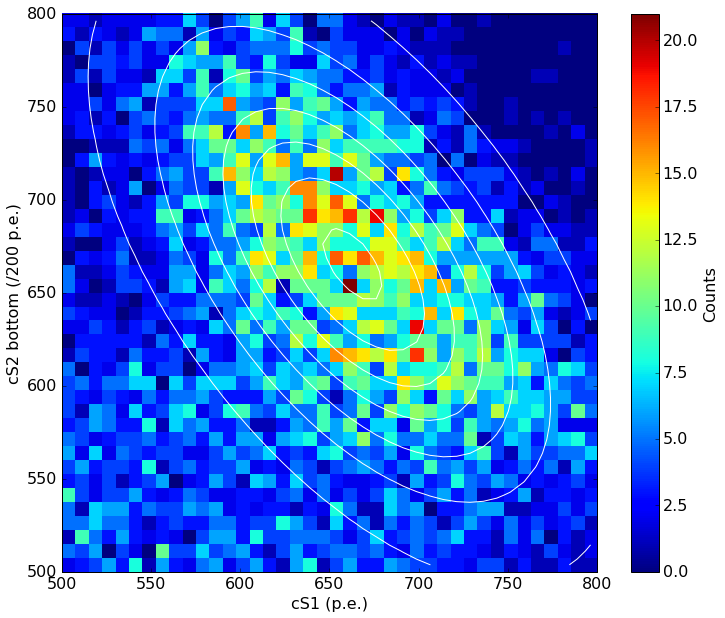

[  9.98531398e+00   6.63082561e+02   6.65326454e+02   6.30863109e+01
   7.28192949e+01  -5.88809805e-01   2.36380860e+00]


In [45]:
# Settings:
binsize = 40
range_s1 = (500,800)
range_s2 = (500,800)

# Better function!
def bivar(xdata_tuple, amplitude, xo,yo,sigma_x,sigma_y,rho,offset):
    (x, y) = xdata_tuple 
    xo = float(xo)
    yo = float(yo)  
    return offset + amplitude*np.exp((-1/(2*(1-rho**2)))*((x-xo)**2/(sigma_x**2) + 
                                                          (y-yo)**2/(sigma_y**2) -
                                                          2*rho*(x-xo)*(y-yo)/(sigma_x*sigma_y)) 
                                    )

s1s2hist = plt.hist2d(np.array(energy_cs1),np.array(energy_cs2), bins=(binsize,binsize),range=(range_s1,range_s2))
plt.colorbar(label = 'Counts')
plt.xlabel("cS1 (p.e.)")
plt.ylabel("cS2 bottom (/200 p.e.)")

# hist_counts: binsize x binsize array of number of counts
# s1 / s2: binsize+1 array of edges

hist_counts,hist_s1, hist_s2, _ = s1s2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_s1[i+1]+hist_s1[i])/2
           for i in range(len(hist_s1)-1)]
y_fit_1d =[(hist_s2[i+1]+hist_s2[i])/2
           for i in range(len(hist_s2)-1)]

x_flat = []
y_flat = []
z_flat = []

# Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
# Has been checked.
for i_y in range(len(y_fit_1d)):
    for i_x in range(len(x_fit_1d)):
        x_flat.append(x_fit_1d[i_x])
        y_flat.append(y_fit_1d[i_y])
        z_flat.append(hist_counts[i_x,i_y])
        
# twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
initial_guess = (20,662,662,100,100,0.78,0)
popt, pcov = curve_fit(bivar, (x_flat, y_flat), z_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# For plotting purposes
data_fitted = np.array([bivar((x, y), *popt)
               for x in x_fit_1d
               for y in y_fit_1d]).flatten()


plt.contour(x_fit_1d, y_fit_1d, data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='w')

plt.savefig('Copy3_Plot16' + '.png', format='png', dpi=300)

plt.show()
print(popt)


anticorrelation angle= -0.905300679042 rad


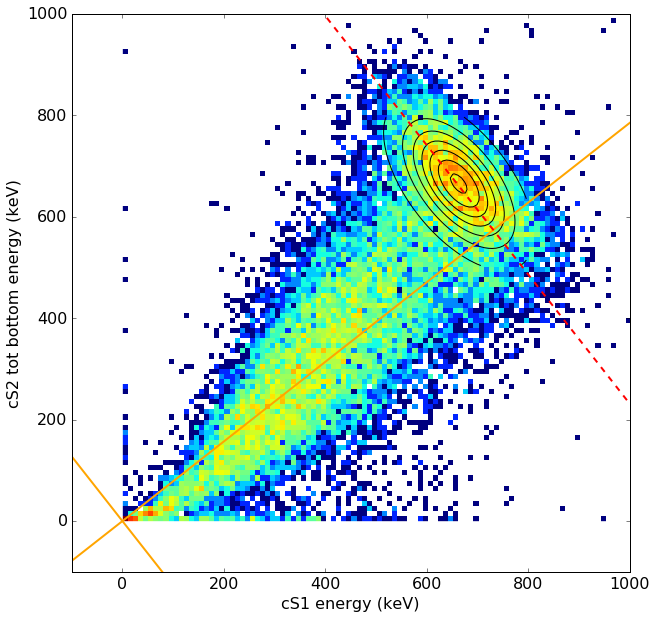

In [46]:
plt.figure(figsize=(10,10))
plt.hist2d(np.array(energy_cs1),np.array(energy_cs2),
           bins=(100,100),range=((0,1000),(0,1000)),cmin=1,norm=LogNorm())
#plt.colorbar(label = 'Counts')
plt.xlabel("cS1 energy (keV)")
plt.ylabel("cS2 tot bottom energy (keV)")
plt.contour(x_fit_1d, np.array(y_fit_1d), data_fitted.reshape(binsize,binsize,order ='F'), 8,colors='black')


sigma_x  = popt[3]
sigma_y  = popt[4]
rho = popt[5]


theta=0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))
theta=theta-np.pi/2 # Angle definition
print('anticorrelation angle=', theta,'rad')


x_list = [x for x in np.arange(-2000,2000,1.)]
v_axis = [-x*np.cos(theta)/np.sin(theta) for x in x_list]
u_axis = [x*np.tan(theta) for x in x_list]

c = 662.*np.cos(theta)-662.*np.sin(theta)

u_axis_2 = [x*np.tan(theta) + c/np.cos(theta) for x in x_list]
v_axis_2 = [-x*np.cos(theta)/np.sin(theta) + c/np.sin(theta) for x in x_list]

plt.plot(x_list,u_axis,color='orange',lw=2)
plt.plot(x_list,v_axis,color='orange',lw=2)
plt.plot(x_list,u_axis_2,color='red',lw=2,ls='--')

plt.xlim(-100,1000)
plt.ylim(-100,1000)
plt.savefig('Copy3_Plot17' + '.png', format='png', dpi=300)

plt.show()

Projection of the energy along the large axis of the ellipse

anticorrelation angle= -0.905300679042 rad


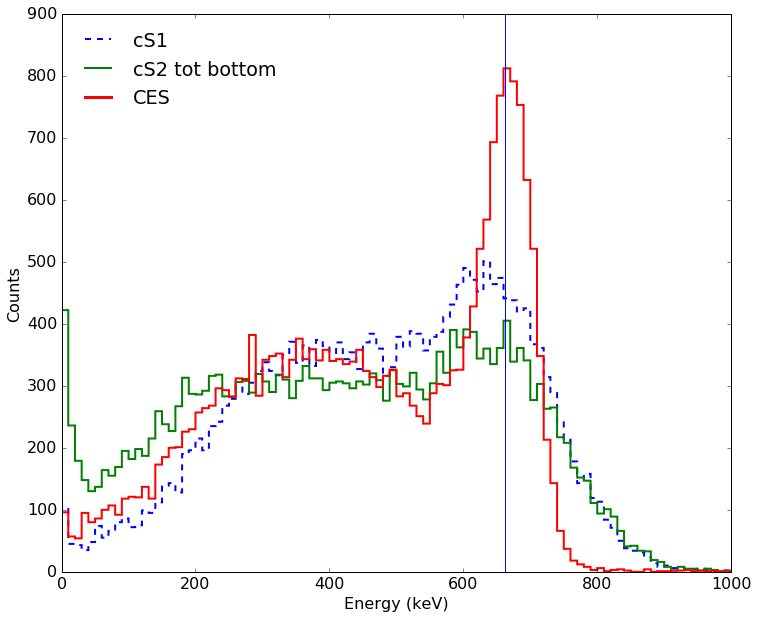

In [47]:
# http://2.bp.blogspot.com/-G-KLeae_EYU/TgdtpzntqvI/AAAAAAAABrI/Rv8Iea9zFVQ/s1600/Screen%2Bshot%2B2011-06-26%2Bat%2B1.33.51%2BPM.png

theta = 0.5*np.arctan(2*rho*(sigma_x*sigma_y)/(sigma_x**2-sigma_y**2))
theta=theta-np.pi/2 # Angle definition

print('anticorrelation angle=',theta,'rad')

# u = x cos(th) + y sin(th)
# v = y cos(th) - x sin(th)
peak_v = 662.*np.cos(theta)-662.*np.sin(theta)

# Parameters for plotting
myrange = (0,1000)
mybins = 100

# Produce histograms
plt.hist(np.array(energy_cs1),bins=mybins,histtype='step',label='cS1',range=myrange,linestyle='dashed',lw=2)
plt.hist(np.array(energy_cs2),bins=mybins,histtype='step',label='cS2 tot bottom',range=myrange,lw=2)
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2)

# Legend
p1,  = plt.plot(0,0,color='blue',linestyle='dashed',lw=2)
p2,  = plt.plot(0,0,color='green',lw=2)
p3,  = plt.plot(0,0,color='red',lw=3)
l1 = plt.legend([p1,p2,p3], ["cS1","cS2 tot bottom","CES"], loc='upper left',frameon=False)

plt.xlabel("Energy (keV)")
plt.ylabel("Counts")
plt.axvline(662)
plt.savefig('Copy3_Plot18' + '.png', format='png', dpi=300)

plt.show()

Energy Resolution 

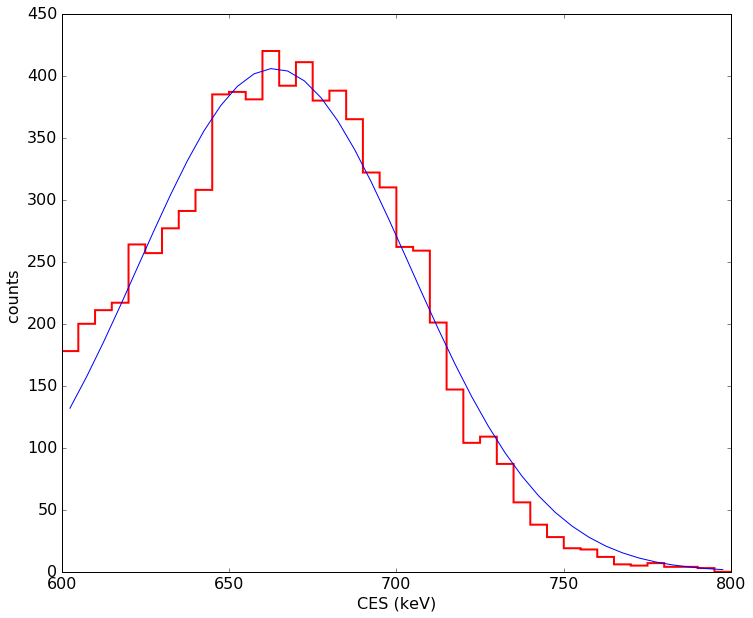

[ 405.90707057  663.44077824   40.64557395]
sigma_CES= 40.6455739485


In [48]:
# Settings!
binsize = 40
myrange=(600,800)
mybins=40
# This is the function to fit
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p is the initial guess

CEShist = plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=mybins,
         histtype='step',label='CES',range=myrange,lw=2, color='red')


plt.xlabel("CES (keV)")
plt.ylabel("counts ")

hist_counts,hist_energy,_=CEShist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d =[(hist_energy[i+1]+hist_energy[i])/2
           for i in range(0,len(hist_energy)-1)]

x_flat = []
y_flat = []


#  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
#  Has been checked.

for i_x in range(len(x_fit_1d)):
    x_flat.append(x_fit_1d[i_x])
    y_flat.append(hist_counts[i_x])
        
#  oneD_Gaussian:

initial_guess = (400,662,100)

popt, pcov = curve_fit(gauss,x_flat, y_flat, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

#  For plotting purposes
data_fitted = np.array([gauss(x, *popt)
               for x in x_fit_1d]).flatten()


plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'))
plt.savefig('Copy3_Plot19' + '.png', format='png', dpi=300)

plt.show()

print(popt)
sigma_CES=popt[2]
print('sigma_CES=', popt[2])

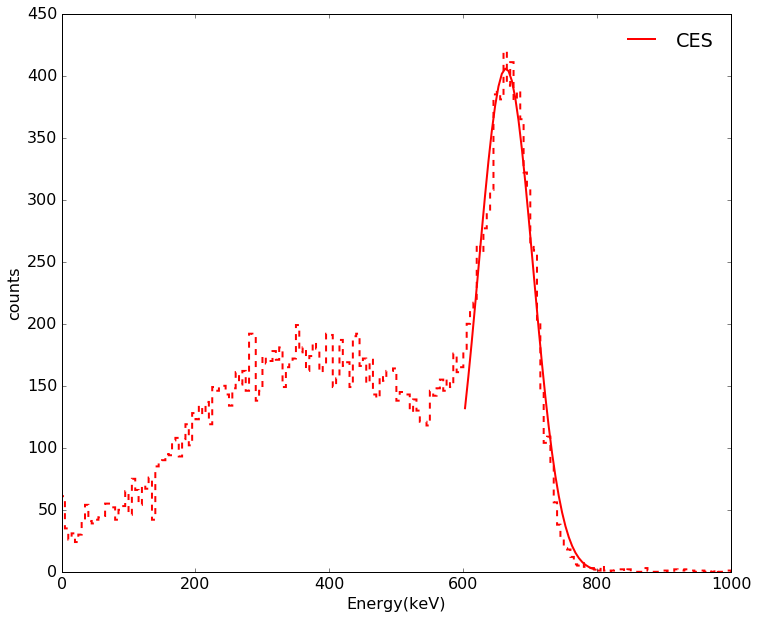

In [49]:
myrange=(0,1000)
binsize=40
plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=200,
         histtype='step',label='CES',range=myrange,lw=2, linestyle ='dashed',color='red')

plt.xlabel("Energy(keV)")
plt.ylabel("counts")
         
plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'),color='red', lw=2)
# Legend
p1,  = plt.plot(0,0,color='red',lw=2)

l1 = plt.legend([p1], ["CES"], loc='upper right',frameon=False)


plt.savefig('Copy3_Plot20' + '.png', format='png', dpi=300)


plt.show()

sigma_cS1= 103.98019647
sigma_cS2= 114.320885745


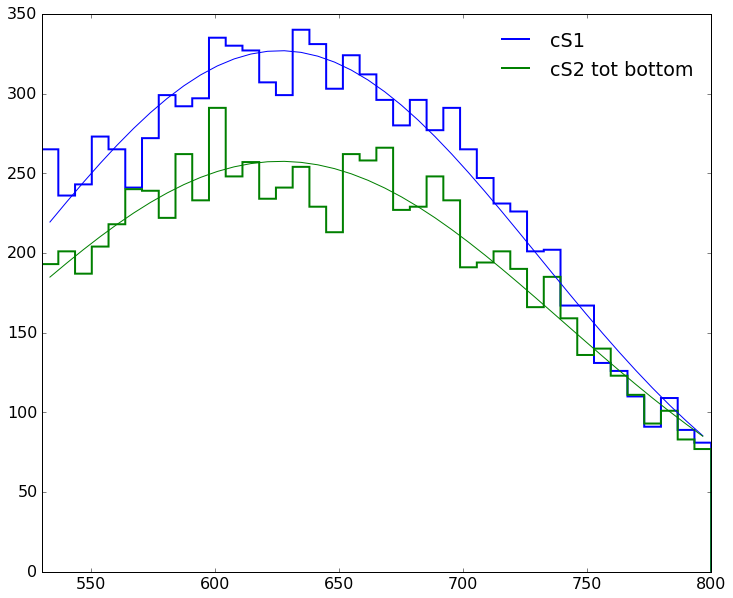

In [50]:
# Settings!
binsize = 40
myrange=(530,800)
mybins=40
# This is the function to fit
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

# p is the initial guess

cS1hist= plt.hist(np.array(energy_cs1),bins=mybins,histtype='step',label='cS1',range=myrange,lw=2)
cS2hist= plt.hist(np.array(energy_cs2),bins=mybins,histtype='step',label='cS2 tot bottom',range=myrange,lw=2)


# plt.xlabel("CES (keV)")
# plt.ylabel("counts ")

hist_counts1,hist_energy1,_=cS1hist
hist_counts2,hist_energy2,_=cS2hist

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d1 =[(hist_energy1[i+1]+hist_energy1[i])/2
           for i in range(0,len(hist_energy1)-1)]

x_flat1 = []
y_flat1 = []


#  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
#  Has been checked.

for i_x in range(len(x_fit_1d1)):
    x_flat1.append(x_fit_1d1[i_x])
    y_flat1.append(hist_counts1[i_x])
        
#  oneD_Gaussian:

initial_guess = (200,660,200)

popt, pcov = curve_fit(gauss,x_flat1, y_flat1, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

#  For plotting purposes
data_fitted1 = np.array([gauss(x, *popt)
               for x in x_fit_1d1]).flatten()


plt.plot(x_fit_1d1, data_fitted1.reshape(binsize,order ='F'), color='blue')
print('sigma_cS1=',popt[2])
sigma_cS1=popt[2]

# Transform bin EDGES to bin CENTERS (decreases size by one)
x_fit_1d2 =[(hist_energy2[i+1]+hist_energy2[i])/2
           for i in range(0,len(hist_energy2)-1)]

x_flat2 = []
y_flat2 = []


#  Loop over all combinations of x and y coordinates and add x, y and z into one n x n list each
#  Has been checked.

for i_x in range(len(x_fit_1d2)):
    x_flat2.append(x_fit_1d2[i_x])
    y_flat2.append(hist_counts2[i_x])
        
#  oneD_Gaussian:

initial_guess = (200,600,200)

popt, pcov = curve_fit(gauss,x_flat2, y_flat2, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

#  For plotting purposes
data_fitted2 = np.array([gauss(x, *popt)
               for x in x_fit_1d2]).flatten()


plt.plot(x_fit_1d2, data_fitted2.reshape(binsize,order ='F'),color='green')
plt.xlim(530,800)
print('sigma_cS2=',popt[2])
sigma_cS2=popt[2]

# Legend
p1,  = plt.plot(0,0,color='blue',lw=2)
p2,  = plt.plot(0,0,color='green',lw=2)
# p3,  = plt.plot(0,0,color='red',lw=3)
l1 = plt.legend([p1,p2], ["cS1","cS2 tot bottom"], loc='upper right',frameon=False)

plt.show()



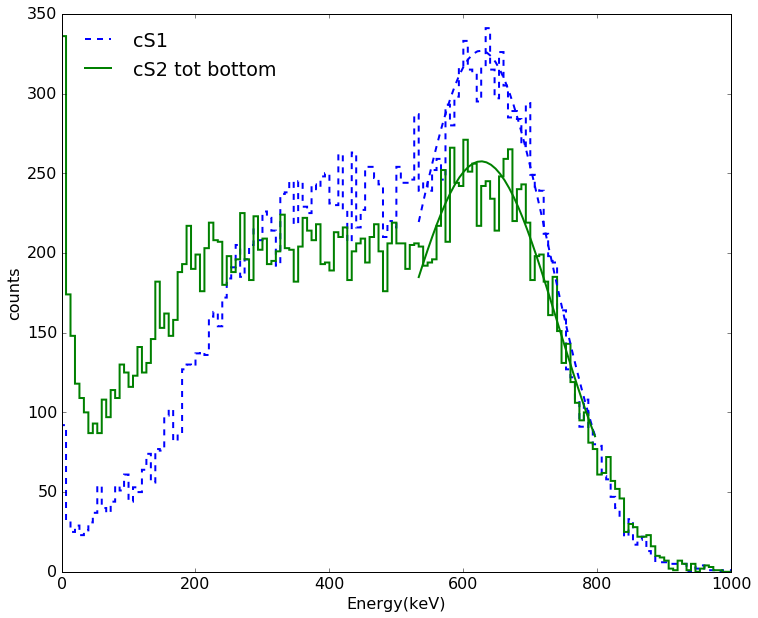

In [51]:
myrange=(0,1000)
binsize=40
# plt.hist(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)),bins=140,
#          histtype='step',label='CES',range=myrange,lw=2, color='red')
plt.hist(np.array(energy_cs1),bins=150,histtype='step',label='cS1',linestyle='dashed',range=myrange,lw=2)
plt.hist(np.array(energy_cs2),bins=150,histtype='step',label='cS2 tot bottom',range=myrange,lw=2)

plt.xlabel("Energy(keV)")
plt.ylabel("counts")
         
# plt.plot(x_fit_1d, data_fitted.reshape(binsize,order ='F'), lw=2)
plt.plot(x_fit_1d1, data_fitted1.reshape(binsize,order ='F'),lw=2,color='blue', linestyle='dashed')
plt.plot(x_fit_1d2, data_fitted2.reshape(binsize,order ='F'),lw=2,color='green')


# Legend
p1,  = plt.plot(0,0,color='blue',linestyle='dashed',lw=2)
p2,  = plt.plot(0,0,color='green',lw=2)
# p3,  = plt.plot(0,0,color='red',lw=3)
l1 = plt.legend([p1,p2], ["cS1","cS2 tot bottom"], loc='upper left',frameon=False)




plt.savefig('Copy3_Plot21' + '.png', format='png', dpi=300)


plt.show()

In [52]:
resCES=sigma_CES/662
resCES=resCES*100
rescS1=sigma_cS1/662
rescS1=rescS1*100
rescS2=sigma_cS2/662
rescS2=rescS2*100

In [62]:
print('resolution=',resCES,'for CES (%)')
print('resolution=',rescS1,'for cS1 (%)')
print('resolution=',rescS2,'for cS2 (%)')

resolution= 6.13981479584 for CES (%)
resolution= 15.7069783187 for cS1 (%)
resolution= 17.2690159736 for cS2 (%)


In [53]:
CES=(662./peak_v*(-np.array(energy_cs1)*np.sin(theta)+np.array(energy_cs2)*np.cos(theta)))
print('CES(keV)=A*cS1(keV)+B*cS2_tot_bottom/200(keV)')
print ('A=', -662./peak_v*np.sin(theta))
print ('B=', 662./peak_v*np.cos(theta))      

CES(keV)=A*cS1(keV)+B*cS2_tot_bottom/200(keV)
A= 0.560240218328
B= 0.439759781672


In [155]:
photopeak=[]
print(len(CES),'events')
for i in range(0,len(CES)):
    if (CES[i]>661.5) & (CES[i]<662.5):
        photopeak.append(CES[i])
print(len(photopeak), 'events in the photopeak')

23091 events
96 events in the photopeak


We need more data 